In [1]:
#Imports
import sys
sys.path.append('../../python/')
import NGC5533_functions as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp

from datetime import datetime
import time as t

In [2]:
starttime = t.time()

data = dp.getXYdata_wXYerr('../data/100kpc_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#change r_dat so it's strictly increasing
r_dat, v_dat, v_err0, v_err1 = (list(a) for a in zip(*sorted(zip(r_dat, v_dat, v_err0, v_err1))))
#converting v_err1 to an array
v_err1 = np.asarray(v_err1)
#Express as weights
weighdata = 1/v_err1

In [3]:
#keeping others but holding them constant, All Parameters
def f(r,n,re,h,pref):
     return np.sqrt(nf.bh_v(r,load=True,path='../')**2 
                    + nf.h_v(r,load=True,path='../')**2 
                    + nf.b_v(r,n,re,load=True,path='../')**2 
                    + nf.d_v(r,h,pref,load=True,path='../')**2)
    
#keeping others but holding them constant, Using Prefactors
def g(r,c,pref):
     return np.sqrt(nf.bh_v(r,load=True,path='../')**2 
                    + nf.h_v(r,load=True,path='../')**2 
                    + c**2*nf.b_v(r,load=True,path='../')**2 
                    + nf.d_v(r,pref,load=True,path='../')**2)
    
#Only Bulge and Disk, All Parameters
def b_d(r,n,re,h,pref):
    return np.sqrt(nf.b_v(r,n,re,load=True,path='../')**2 + nf.d_v(r,h,pref,load=True,path='../')**2)

#Only Bulge and Disk, Using Prefactors
def b_d2(r,c,pref):
    return np.sqrt(c**2*nf.b_v(r,load=True,path='../')**2 + nf.d_v(r,pref,load=True,path='../')**2)

In [4]:
#Fit, Keeping rest constant, All Parameters

#Setup
l_mod = lm.Model(f)
l_params = l_mod.make_params()
#Bulge Params
l_params.add('n', value=nf.n_c, min=0) 
l_params.add('re', value=nf.re_c, min=0) 
#Disk Params
l_params.add('h', value=nf.h_c, min=0, max=1000)
l_params.add('pref', value=nf.pref_def, min=0)
#Do fit
l_fit = l_mod.fit(v_dat,l_params,r=r_dat,weights=weighdata)

../../python\NGC5533_functions.py:308: RuntimeWarning: overflow encountered in cosh
  return d_durho0(r, h, d_rho00)*np.power(np.cosh(z/z0(h)), -2)
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestim

In [5]:
#Fit, Keeping rest constant, Using Prefactors

#Setup
g_mod = lm.Model(g)
g_params = g_mod.make_params()
#Bulge Params
g_params.add('c', value=1, min=0) 
#Disk Params
g_params.add('pref', value=nf.pref_def, min=0)
#Do fit
g_fit = g_mod.fit(v_dat,g_params,r=r_dat,weights=weighdata)

In [6]:
#Fit, B and D Only, All Parameters

#Setup
bd_mod = lm.Model(b_d)
bd_params = bd_mod.make_params()
#Bulge Params
bd_params.add('n', value=nf.n_c, min=0) 
bd_params.add('re', value=nf.re_c, min=0) 
#Disk Params
bd_params.add('h', value=nf.h_c, min=0, max=1000)
bd_params.add('pref', value=nf.pref_def, min=0)
#Do fit
bd_fit = bd_mod.fit(v_dat,bd_params,r=r_dat,weights=weighdata)

In [7]:
#Fit, B and D Only, Using Prefactors

#Setup
bd2_mod = lm.Model(b_d2)
bd2_params = bd2_mod.make_params()
#Bulge Params
bd2_params.add('c', value=1, min=0) 
#Disk Params
bd2_params.add('pref', value=nf.pref_def, min=0)
#Do fit
bd2_fit = bd2_mod.fit(v_dat,bd2_params,r=r_dat,weights=weighdata)

In [8]:
#Define curves to plot

l_dict = l_fit.best_values
l_n = l_dict['n']
l_re = l_dict['re']
l_h = l_dict['h']
l_pref = l_dict['pref']
l_curve = f(r_dat,l_n,l_re,l_h,l_pref)

g_dict = g_fit.best_values
g_c = g_dict['c']
g_pref = g_dict['pref']
g_curve = g(r_dat,g_c,g_pref)

bd_dict = bd_fit.best_values
bd_n = bd_dict['n']
bd_re = bd_dict['re']
bd_h = bd_dict['h']
bd_pref = bd_dict['pref']

bd2_dict = bd2_fit.best_values
bd2_c = bd2_dict['c']
bd2_pref = bd2_dict['pref']

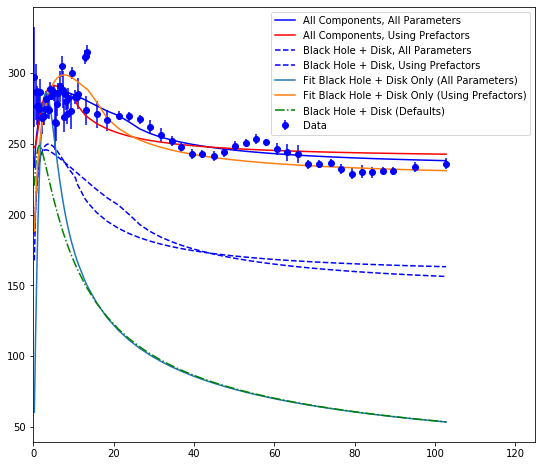

In [10]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,125)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,'b-',label='All Components, All Parameters')
plt.plot(r_dat,g_curve,'r-',label='All Components, Using Prefactors')
plt.plot(r_dat,b_d(r_dat,l_n,l_re,l_h,l_pref),'b--',label='Black Hole + Disk, All Parameters')
plt.plot(r_dat,b_d2(r_dat,g_c,g_pref),'b--',label='Black Hole + Disk, Using Prefactors')
plt.plot(r_dat,b_d(r_dat,bd_n,bd_re,bd_h,bd_pref),label='Fit Black Hole + Disk Only (All Parameters)')
plt.plot(r_dat,b_d2(r_dat,bd2_c,bd2_pref),label='Fit Black Hole + Disk Only (Using Prefactors)')
plt.plot(r_dat,b_d(r_dat,nf.n_c,nf.re_c,nf.h_c,nf.pref_def),'g-.',label='Black Hole + Disk (Defaults)')

plt.legend()
plt.show()

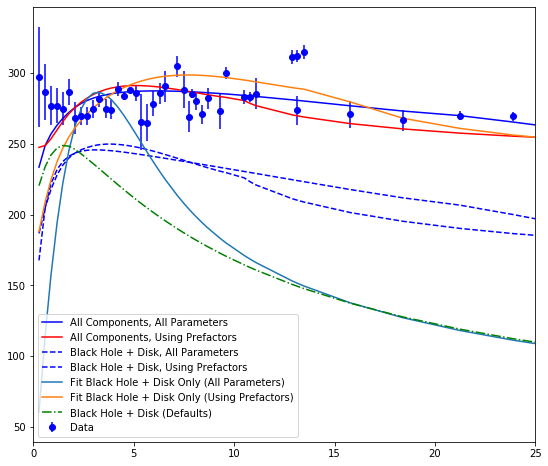

In [11]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,25)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,'b-',label='All Components, All Parameters')
plt.plot(r_dat,g_curve,'r-',label='All Components, Using Prefactors')
plt.plot(r_dat,b_d(r_dat,l_n,l_re,l_h,l_pref),'b--',label='Black Hole + Disk, All Parameters')
plt.plot(r_dat,b_d2(r_dat,g_c,g_pref),'b--',label='Black Hole + Disk, Using Prefactors')
plt.plot(r_dat,b_d(r_dat,bd_n,bd_re,bd_h,bd_pref),label='Fit Black Hole + Disk Only (All Parameters)')
plt.plot(r_dat,b_d2(r_dat,bd2_c,bd2_pref),label='Fit Black Hole + Disk Only (Using Prefactors)')
plt.plot(r_dat,b_d(r_dat,nf.n_c,nf.re_c,nf.h_c,nf.pref_def),'g-.',label='Black Hole + Disk (Defaults)')

plt.legend()
plt.show()

In [12]:
print('Fit information for all-component fit (All Parameters):')
l_fit

Fit information for all-component fit (All Parameters):


In [13]:
print('Fit information for all-component fit (Using Prefactors):')
g_fit

Fit information for all-component fit (Using Prefactors):


In [14]:
print('Fit information for two-component fit (All Parameters):')
bd_fit

Fit information for two-component fit (All Parameters):


In [15]:
print('Fit information for two-component fit (Using Prefactors):')
bd2_fit

Fit information for two-component fit (Using Prefactors):


In [16]:
endtime = t.time()
print('Total Time:')
print(str(endtime - starttime)+' seconds')
print('')

print('Timestamp:')
print(datetime.now())

Total Time:
117445.57718706131 seconds

Timestamp:
2019-10-14 07:38:26.486486
